A Tutorial on Autoencoders
====

In this notebook, we briefly experiment with a variational autoencoder.

## Setup

We import our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from models.variational_autoencoder import VAE

Set eager mode for `tfds`.

In [2]:
tf.compat.v1.enable_eager_execution()

We set our GPU memory growth for efficiency.

In [3]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)


Set the random number generator seed value.

In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

We set the batch size and the number of epochs.

In [5]:
BATCH_SIZE = 64
EPOCHS = 10

## Dataset

We load the MNIST dataset.

In [6]:
train_dataset = tfds.load("mnist", split=tfds.Split.TRAIN)

We define a normalization function.

In [7]:
def normalize(example):
    features = example["image"]
    features = tf.reshape(features, [-1, 784])
    features = tf.cast(features, tf.float32)
    features = features / 255.
    return features, features

We customize our `tf.data.Dataset` pipeline.

In [8]:
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(BATCH_SIZE, True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Model

Let's instantiate our VAE.

In [9]:
model = VAE(intermediate_dim=128, latent_dim=64, original_dim=784)

Call the model once to get a summary.

In [10]:
for batch_features, _ in train_dataset.take(1):
    model(batch_features)
    break

Display the model summary.

In [11]:
model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  116992    
_________________________________________________________________
decoder (Decoder)            multiple                  109456    
Total params: 226,448
Trainable params: 226,448
Non-trainable params: 0
_________________________________________________________________


Instantiate an optimizer.

In [12]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

Train the model for 10 epochs.

In [13]:
loss_values = []

for epoch in range(EPOCHS):
    epoch_loss = []
    for batch_features, batch_features in train_dataset:
        with tf.GradientTape() as tape:
            reconstruction = model(batch_features)
            train_loss = tf.losses.binary_crossentropy(y_pred=reconstruction,
                                                       y_true=batch_features)
            train_loss = tf.reduce_mean(train_loss)
        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        epoch_loss.append(train_loss)
    loss_values.append(epoch_loss)
    if (epoch + 1) % 2 == 0:
        epoch_loss = tf.reduce_mean(epoch_loss)
        print('epoch {}/{} : mean loss = {}'.format(epoch + 1, EPOCHS, epoch_loss))

epoch 2/10 : mean loss = 0.09229772537946701
epoch 4/10 : mean loss = 0.08669552952051163
epoch 6/10 : mean loss = 0.08511661738157272
epoch 8/10 : mean loss = 0.0843391865491867
epoch 10/10 : mean loss = 0.08415219932794571


Load the test data.

In [14]:
test_dataset = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
test_dataset = tfds.as_numpy(test_dataset)
test_features = test_dataset["image"]
test_features = test_features.astype("float32") / 255.

Plot the training loss.

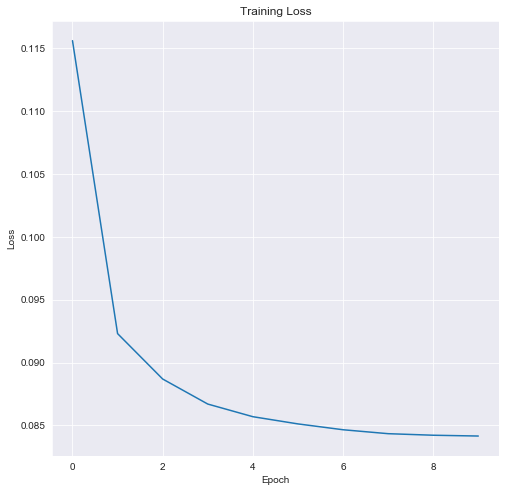

In [15]:
loss_values = [tf.reduce_mean(loss_value) for loss_value in loss_values]

sns.set_style("darkgrid")

plt.figure(figsize=(8, 8))
plt.plot(loss_values)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss")
plt.show()

Visualize the reconstruction and the original data.

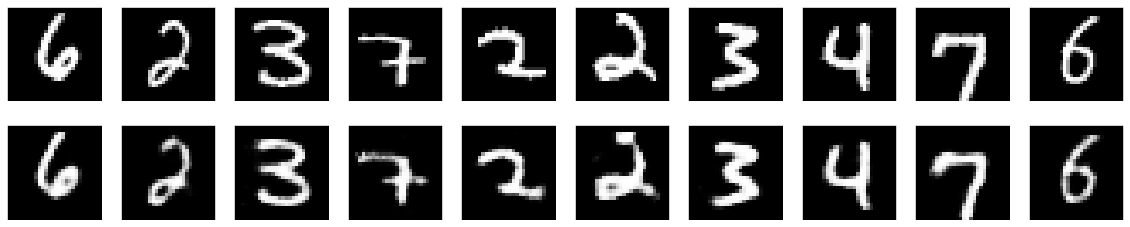

In [16]:
number = 10
plt.figure(figsize=(20, 4))

for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    test_image = test_features[index]
    test_image = test_image.reshape(28, 28)
    plt.imshow(test_image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    reconstructed = model(test_features[index].reshape(-1, 784))
    reconstructed = reconstructed.numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
model.save_weights("export/vae/mnist", save_format="tf")